In [107]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 定义LeNet模型
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 假设输入图像大小为32x32
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [108]:
# 使用nn.Sequential定义LeNet模型
nn_LeNet = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 10)
)

X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in nn_LeNet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
ReLU output shape: 	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
ReLU output shape: 	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [109]:
# 定义一个输入张量X
X = torch.randn(1, 1, 32, 32)  # 批大小为1，单通道，图像大小为32x32

# 初始化LeNet模型
model = LeNet()

# 打印通过LeNet模型的输出
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [110]:
# 自定义加载数据集类
class FashionMNIST(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.root = root
        self.transform = transform
        self.train = train
        if self.train:
            self.data_file = os.path.join(root, 'train-images-idx3-ubyte')
            self.labels_file = os.path.join(root, 'train-labels-idx1-ubyte')
        else:
            self.data_file = os.path.join(root, 't10k-images-idx3-ubyte')
            self.labels_file = os.path.join(root, 't10k-labels-idx1-ubyte')
        
        self.data = self._read_image_file(self.data_file)
        self.labels = self._read_label_file(self.labels_file)
    
    def _read_image_file(self, path):
        with open(path, 'rb') as f:
            f.read(16)
            data = np.frombuffer(f.read(), dtype=np.uint8)
        return data.reshape(-1, 28, 28)
    
    def _read_label_file(self, path):
        with open(path, 'rb') as f:
            f.read(8)
            labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img, target = self.data[index], self.labels[index]
        img = Image.fromarray(img, mode='L')  # 将图像转换为PIL图像
        if self.transform:
            img = self.transform(img)
        return img, target


In [111]:
# 设置超参数
batch_size = 64
learning_rate = 0.001
epochs = 20


# 数据路径
data_dir = '/home/wood/github/DL-learn/DL/d2l/pytorch/data/FashionMNIST/raw'

In [112]:
# 数据预处理和加载
transform = transforms.Compose([
    # transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = FashionMNIST(root=data_dir, train=True, transform=transform)
test_dataset = FashionMNIST(root=data_dir, train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [113]:
# 初始化模型、损失函数和优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# model = LeNet().to(device)
model = nn_LeNet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# summary(model, (1, 32, 32))  # 使用torchsummary打印模型摘要

# 用于存储损失和准确率
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []


cuda


In [114]:
# 训练模型
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    
    # 测试模型
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)
    
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Test Loss: {test_loss/len(test_loader):.4f}, Test Acc: {test_accuracies[-1]:.2f}%')


Epoch [1/20], Train Loss: 0.5902, Train Acc: 78.34%, Test Loss: 0.4177, Test Acc: 85.03%
Epoch [2/20], Train Loss: 0.3765, Train Acc: 86.21%, Test Loss: 0.3581, Test Acc: 87.07%
Epoch [3/20], Train Loss: 0.3234, Train Acc: 88.13%, Test Loss: 0.3469, Test Acc: 87.25%
Epoch [4/20], Train Loss: 0.2954, Train Acc: 89.14%, Test Loss: 0.3133, Test Acc: 88.33%
Epoch [5/20], Train Loss: 0.2712, Train Acc: 90.00%, Test Loss: 0.2901, Test Acc: 89.36%
Epoch [6/20], Train Loss: 0.2530, Train Acc: 90.79%, Test Loss: 0.2920, Test Acc: 89.26%
Epoch [7/20], Train Loss: 0.2398, Train Acc: 91.02%, Test Loss: 0.2838, Test Acc: 89.42%
Epoch [8/20], Train Loss: 0.2250, Train Acc: 91.59%, Test Loss: 0.2737, Test Acc: 89.68%
Epoch [9/20], Train Loss: 0.2133, Train Acc: 92.06%, Test Loss: 0.2830, Test Acc: 89.85%
Epoch [10/20], Train Loss: 0.2027, Train Acc: 92.44%, Test Loss: 0.2906, Test Acc: 89.64%
Epoch [11/20], Train Loss: 0.1925, Train Acc: 92.75%, Test Loss: 0.2657, Test Acc: 90.51%
Epoch [12/20], Trai

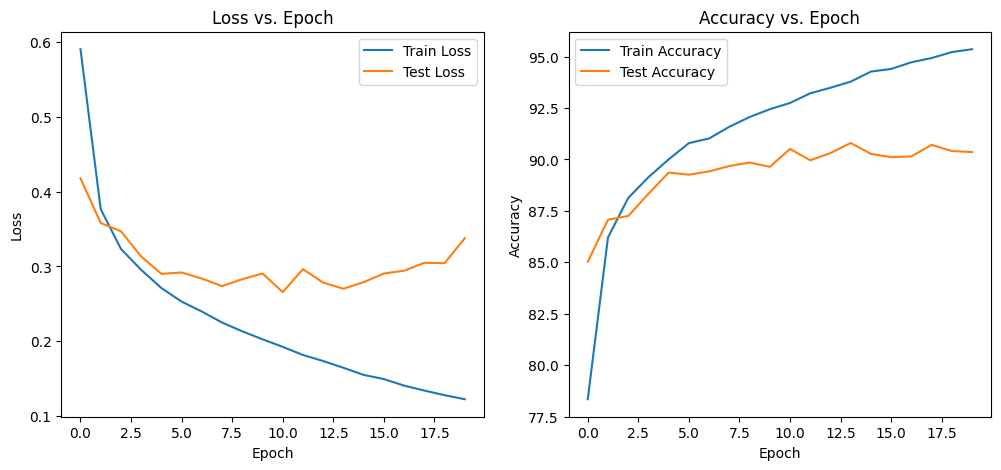

In [115]:
# 绘制损失和准确率曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.show()

# 保存模型
torch.save(model.state_dict(), 'lenet_fashionmnist.pth')